<a name="top"> <h1>01. Preprocessing</h1> <a>

<p>Payments Fraud Practice<br />
<strong>Aprendizaje Autom&aacute;tico</strong><br />
<strong>Master Universitario en Ciencia de Datos</strong></p>

<p>&nbsp;</p>

<p style="text-align:right">Antonio Nogués Podadera (<em>antonio.nogues@cunef.edu</em>)</p>
<p style="text-align:right">V&iacute;ctor Viloria V&aacute;zquez (<em>victor.viloria@cunef.edu</em>)</p>


<hr style="border:1px solid gray">

### Estructura

[0. Introducción](#introduccion) 


[1. Importación de librerias y funciones](#librerias) 


[2. Observación de Outliers](#outliers) 

   - Connection time
   - User Number
   - Age
   
[3. Creación de Pipelines](#pipelines) 

   - Listas de variables 
   - Pipelines según el tipo de variable
   - Pipeline de preprocesado
   
   
[4. Selección de variables](#variables)

[5.Separación en Train, Validación y Test](#sets)

<hr style="border:1px solid gray">

# <a name="introduccion"> 0. Introducción <a> 


En este documento realizaremos un preprocesado de las variables para poder utilizarlas en los modelos. Para ello nos basaremos en el análisis exploratorio, que se puede encontrar en el documento `00_EDA`.

# <a name="librerias"> 1. Importación de librerias y funciones <a> 


Importamos las librerias utilizadas para el preprocesamiento:

In [1]:
from sklearn.model_selection import train_test_split 
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import pickle
import warnings
warnings.filterwarnings('ignore')

Importamos las funciones a utilizar:

In [2]:
from aux_functions import *

# <a name="outliers"> 2. Observación de Outliers <a> 


En este apartado estudiaremos mas detenidamente la distribución de los outliers y si afectan a la aplicación de los modelos. Para ello representaremos graficamente aquellas variables con mayor número de outliers.

In [3]:
# Load the processed dataset saved in the EDA.

payments_df = pd.read_csv('../data/processed/payments_df.csv', index_col=0)

# Create a DF with the numerical variables of 'payments_df'.

num_var_df = payments_df[['step', 'amount', 'connection_time', 'oldbalanceOrg','age', 'newbalanceOrig', 'user_number','oldbalanceDest','newbalanceDest']]

# Create a dataframe 'outliers_df' with the number of outliers and percentage in a dataset.

outliers_df = get_deviation_of_mean_perc(payments_df, num_var_df, target='isFraud', multiplier=1.5)

# Display outliers_df.

outliers_df

,0.0,1.0,Variable,Número de outliers,Porcentaje outliers
0,0.974320,0.025680,step,22586,0.021540
1,0.990036,0.009964,amount,45867,0.043742
2,0.998897,0.001103,connection_time,141484,0.134930
3,0.998812,0.001188,oldbalanceOrg,58947,0.056216
4,0.999072,0.000928,age,131463,0.125373
5,0.999950,0.000050,newbalanceOrig,59807,0.057036
6,0.998826,0.001174,user_number,140512,0.134003
7,0.999421,0.000579,oldbalanceDest,57040,0.054398
8,0.998648,0.001352,newbalanceDest,59187,0.056445


Como ya vimos durante el EDA, las variables con mayor número de outliers son : `connection_time`, `user_number` y `age`. Procedemos a representarlas graficamente:

## 2.1. Connection time 

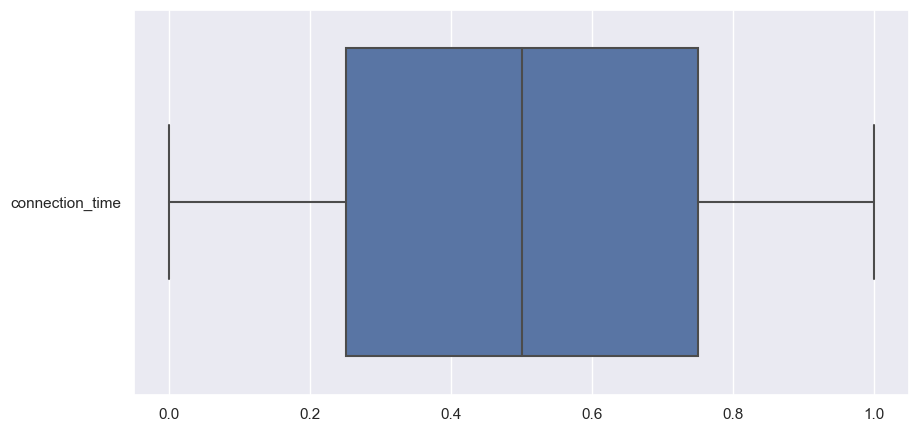

In [4]:
# Config size of the plot.

sns.set(rc={'figure.figsize':(10,5)})

# Create a boxplot of connection_time.

sns.boxplot(data=payments_df[['connection_time']], orient="h")

# Display the plot.

plt.show()

Tal y como observamos no detectamos ningun valor considerado como outlier dentro del gráfico por lo que mantenderemos todos los datos de la variable para insertarlos en el modelo.

## 2.2. User Number

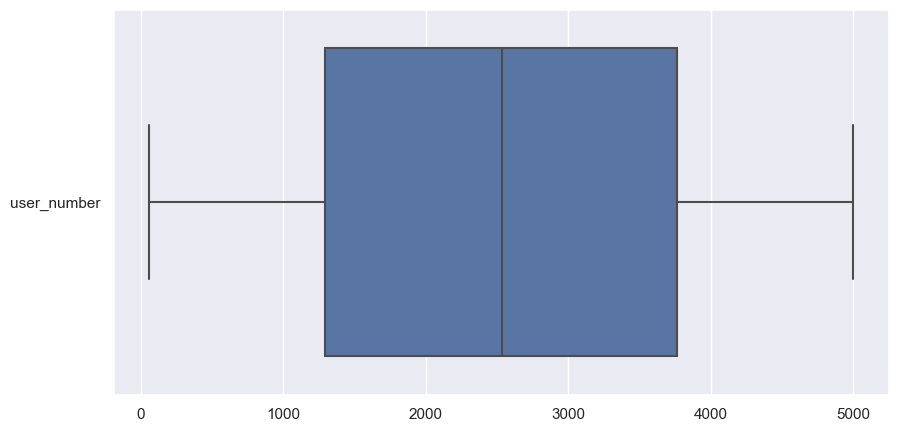

In [5]:
# Config size of the plot.

sns.set(rc={'figure.figsize':(10,5)})

# Create a boxplot of 'user_number'.

sns.boxplot(data=payments_df[['user_number']], orient="h")

# Display the plot.

plt.show()

Tal y como observamos no detectamos ningun valor considerado como outlier dentro del gráfico por lo que mantenderemos todos los datos de la variable para insertarlos en el modelo.

## 2.3. Age

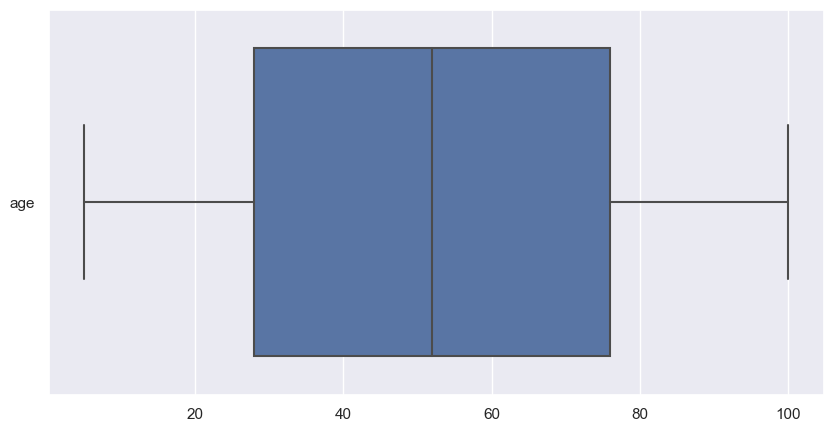

In [6]:
# Config size of the plot.

sns.set(rc={'figure.figsize':(10,5)})

# Create a boxplot of 'age'.

sns.boxplot(data=payments_df[['age']], orient="h")

# Display the plot.

plt.show()

Tal y como observamos no detectamos ningun valor considerado como outlier dentro del gráfico por lo que mantenderemos todos los datos de la variable para insertarlos en el modelo.

#  <a name="pipelines"> 3. Creación de Pipelines  <a>

En este apartado crearemos un pipelines de preprocesado para aplicar la transformación de las variables previamente a realizar los modelos. Este pipeline, diferenciará segun el tipo de variable: numérica oo categórica.

### 3.1. Listas de variables

Dado que tenemos diferentes tipos de variables, creamos un par de listas para diferenciarlas y tratarlas de forma diferente posteriormente.  

In [7]:
# Creation a list with the name of the categorical variables.

categ_var = ['type', 'gender', 'device', 'zone','security_alert','nameDest', 'nameOrig', 'nameDest']

# Creation a list with the name of the numerical variables.

num_var = ['step', 'amount', 'connection_time', 'oldbalanceOrg','age', 'newbalanceOrig', 'user_number','oldbalanceDest','newbalanceDest']

### 3.2. Pipelines según el tipo de variable

#### 3.2.1 Variables categóricas

Para las variables categóricas, **en primer lugar, transformará los valores nulos a una nueva categoría, `unknow`**. Para poder trabajar con ellos como una variable aparte.

**Posteriormente debido a su bajo número de categorías (máx 5), realizaremos una transformación mediante One Hot Encoder**, ideal para categorías con pocos grupos.

In [8]:
# Creation of a pipeline for categorical variables that fill NaN values to 'unknow' first,
# then apply the OneHotEncoder preprocessing.

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknow')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])


#### 3.2.2 Variables numéricas

En cuanto a las variables numéricas, observamos en el EDA que **no existian valores nulos** en este tipo de variables, por lo que no será necesario ninguna transformación en cuanto a ese tipo de datos. 

Sin embargo, **realizaremos un preprocesado de estandarización**, para que los **datos sean internamente coherentes y permita una mayor eficiencia en la optimización del modelo**.

In [9]:
# Creation of a pipeline for numerical variables that standardize each variable

num_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

### 3.3. Pipeline de preprocesado

Una vez creados los diferentes pipelines para cada tipo de variable, los unificaremos en un Preprocesador, que transformará las variables previamente de entrenar los modelos.

In [10]:
# Creation of a preprocessor for the categorical and numerical variables

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_transformer, categ_var),
        ('num', num_transformer, num_var)
    ]
)

# Save the preprocessor as .pickle
with open('../models/preprocessor.pickle', 'wb') as f:
    pickle.dump(preprocessor, f)

## <a name="variables"> 4. Selección de variables <a>

Para la creación de los modelos trabajaremos con todas las variables analizadas en el EDA, ya que consideramos que todas podrían aportar más valor a nuestro modelo. **La única variable que se ha descartado fue la de `race` debido a motivos éticos**.

## <a name="sets"> 5. Separación en Train, Validación y Test <a>

Una vez realizado el EDA, procedemos a crear los diferentes sets de train, validacion y test. De manera que **para la creación de nuestros modelos de Machine Learning dispondremos de 3 sets: train, validación y test**.

En primer lugar separamos los distintos valores (X) de la variable objetivo (Y)

In [11]:
# Separation of variables X  from the target variable Y 

X = payments_df.drop('isFraud', axis=1)
Y = payments_df['isFraud']

Creamos el set de Test:

In [12]:
# Division into train and test sets.

x_train_all, x_test, y_train_all, y_test = train_test_split(X, Y, test_size=0.25, random_state=12345, stratify=Y)

Creamos el set de train y validación:

In [13]:
# Creation of a validation set shuffled from the training set. Selecting a 25% of the total for the 'val_df'.

x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, test_size=0.25, random_state=12345, stratify=y_train_all)

Exportamos los sets como csv para poder cargarlos en la elaboración de los modelos.

In [14]:
# Export the train, validation and test variables as csv in the folder of processed data.

x_train.to_csv("../data/processed/x_train.csv")
y_train.to_csv("../data/processed/y_train.csv")

x_val.to_csv("../data/processed/x_val.csv")
y_val.to_csv("../data/processed/y_val.csv")

x_train_all.to_csv("../data/processed/x_train_all.csv")
y_train_all.to_csv("../data/processed/y_train_all.csv")

x_test.to_csv("../data/processed/x_test.csv")
y_test.to_csv("../data/processed/y_test.csv")

[Ir arriba del documento](#top)